In [62]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import glob
%config Completer.use_jedi = False
#torch.cuda.set_device(1)

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.7.8
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.8.1+cu102
nvidia driver : 440.33
torch cuda    : 10.2 / is available
torch cudnn   : 7605 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15109MB | Tesla T4

=== Environment === 
platform      : Linux-4.9.0-13-amd64-x86_64-with-debian-9.13
distro        : #1 SMP Debian 4.9.228-1 (2020-07-05)
conda env     : base
python        : /opt/conda/envs/fastai_v1/bin/python
sys.path      : 
/home/jupyter/retinanet_fastai
/opt/conda/envs/fastai_v1/lib/python37.zip
/opt/conda/envs/fastai_v1/lib/python3.7
/opt/conda/envs/fastai_v1/lib/python3.7/lib-dynload
/opt/conda/envs/fastai_v1/lib/python3.7/site-packages
/opt/conda/envs/fastai_v1/lib/python3.7/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional

In [67]:
annot_path = Path('/home/jupyter/data/1_class_data/anno_dest/')
img_path = Path('/home/jupyter/data/1_class_data/img_dest/')

In [68]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):
    filename=xml_file.split('/')[6][:-4]
    filename=filename+'.png'
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_cls = []
    final_list=[]
    list_with_single_boxes=[]
    for boxes in root.iter('object'):
        filename = str(root.find('filename').text)
        filename = filename+'.png'
        classes = str(boxes.find('name').text)

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [ymin, xmin, ymax, xmax]
        
        if list_with_single_boxes == []:
            list_with_single_boxes = [0,0,0,0]
        list_with_all_boxes.append(list_with_single_boxes)
        list_with_cls.append(classes)

    if list_with_single_boxes == []:
        list_with_all_boxes = [0,0,0,0]
        list_with_cls=['background']
    return filename, list_with_all_boxes, list_with_cls

In [69]:
input_xml_list = sorted(glob.glob(str(annot_path) + '/*.xml'))

In [70]:
filenames=[]
bboxes=[]
classes=[]
lbl2bbox=[]
for files in range(len(input_xml_list)):
    names, bbox, cls = read_content(input_xml_list[files])
    filenames.append(names)
    lbl2bbox.append(tuple((bbox,cls)))

In [71]:
img2bbox=dict(zip(filenames,lbl2bbox))

In [72]:
img_df=pd.DataFrame(img2bbox.keys())

In [73]:
img2bbox['000001.png']

([[19, 27, 33, 185], [39, 19, 52, 169], [59, 19, 71, 32]],
 ['text', 'text', 'text'])

In [74]:
img = open_image(str(img_path) + '/000001.png')

In [75]:
bbox = ImageBBox.create(*img.size, img2bbox['000001.png'][0])

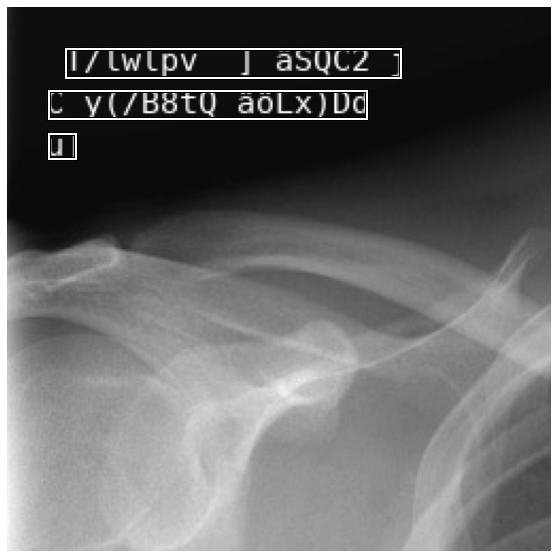

In [76]:
img.show(figsize=(10,10), y=bbox)

In [77]:
def get_y_func(o):
    name = o.split('/')[-1]
    ibb = img2bbox[name]
    bbox = ibb[0]
    labels = ibb[1]
    l=tuple([bbox, labels])
    return l

In [78]:
#test_path_anno = Path('/home/jupyter/data/1_class_test/anno_dest/')

In [79]:
#mmiv path
#test_img_path = Path('/home/fredrikmathisen/Documents/data/test/')
#gcloud path
test_img_path = Path('/home/jupyter/data/test/')
test_img_list = sorted(glob.glob(str(test_img_path) + '/with_text/00000000_*.png'))
test_img_list

['/home/jupyter/data/test/with_text/00000000_01_01.png',
 '/home/jupyter/data/test/with_text/00000000_01_02.png',
 '/home/jupyter/data/test/with_text/00000000_01_03.png',
 '/home/jupyter/data/test/with_text/00000000_01_04.png',
 '/home/jupyter/data/test/with_text/00000000_02_01.png',
 '/home/jupyter/data/test/with_text/00000000_02_02.png',
 '/home/jupyter/data/test/with_text/00000000_02_03.png',
 '/home/jupyter/data/test/with_text/00000000_02_04.png',
 '/home/jupyter/data/test/with_text/00000000_03_01.png',
 '/home/jupyter/data/test/with_text/00000000_03_02.png',
 '/home/jupyter/data/test/with_text/00000000_03_03.png',
 '/home/jupyter/data/test/with_text/00000000_03_04.png',
 '/home/jupyter/data/test/with_text/00000000_04_01.png',
 '/home/jupyter/data/test/with_text/00000000_04_02.png',
 '/home/jupyter/data/test/with_text/00000000_04_03.png',
 '/home/jupyter/data/test/with_text/00000000_04_04.png']

In [80]:
#input_xml_list_test = sorted(glob.glob(str(test_path_anno) + '/.xml'))

In [81]:
# filenames_test=[]
# # bboxes=[]
# # classes=[]
# # lbl2bbox=[]
# for files in range(len(input_xml_list_test)):
#     names_test, bbox_test, cls_test = read_content(input_xml_list_test[files])
#     filenames_test.append(names_test)
#     lbl2bbox.append(tuple((bbox,cls)))

In [82]:
filenames_test=[]
# bboxes=[]
# classes=[]
# lbl2bbox=[]
for files in range(len(test_img_list)):
    names_test = test_img_list[files]
    names_test = names_test[34:]
    #print(names_test[34:])
    filenames_test.append(names_test)
    
#     lbl2bbox.append(tuple((bbox,cls)))

In [83]:
test_series = pd.Series(filenames_test)

In [84]:
test_series

0     00000000_01_01.png
1     00000000_01_02.png
2     00000000_01_03.png
3     00000000_01_04.png
4     00000000_02_01.png
5     00000000_02_02.png
6     00000000_02_03.png
7     00000000_02_04.png
8     00000000_03_01.png
9     00000000_03_02.png
10    00000000_03_03.png
11    00000000_03_04.png
12    00000000_04_01.png
13    00000000_04_02.png
14    00000000_04_03.png
15    00000000_04_04.png
dtype: object

In [85]:
test_df=pd.DataFrame()

In [86]:
test_df['image_id']=test_series

In [87]:
test_df.head()

image_id
0  00000000_01_01.png
1  00000000_01_02.png
2  00000000_01_03.png
3  00000000_01_04.png
4  00000000_02_01.png

In [88]:
ts = (ObjectItemList.from_df(test_df,test_img_path, folder = 'with_text' ,cols='image_id'))
image_id = test_df.image_id.values

In [89]:
def get_data(bs, size):
    src = ObjectItemList.from_df(img_df, img_path)
    src = src.split_by_rand_pct()
    src = src.label_from_func(get_y_func)
    src = src.transform(size=size)#, padding_mode='zeros', resize_method=ResizeMethod.SQUISH, tfm_y=True)
    src = src.add_test(ts)
    return src.databunch(path=img_path, bs=bs, collate_fn=bb_pad_collate)

In [90]:
data = get_data(45, 256)

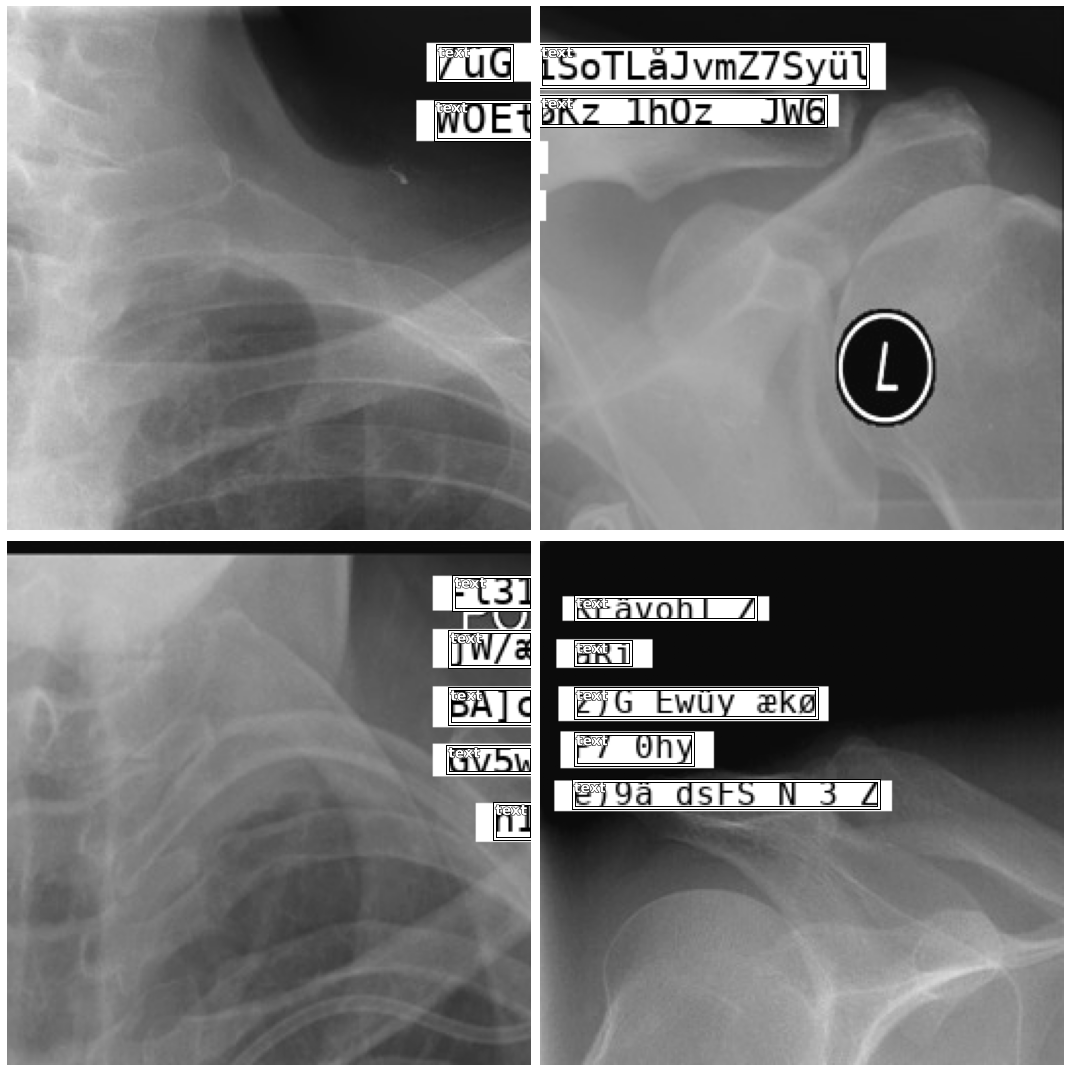

In [91]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [92]:
data.classes

['background', 'text']

In [93]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.05, 0.25, 0.4, 0.75], scales=[0.35, 0.5, 0.6,0.8, 1, 1.25, 1.6])

In [94]:
a=[0.05, 0.25, 0.4,0.75]
b=[0.35, 0.5, 0.6,0.8, 1, 1.25, 1.6]
print(len(a)*len(b))

28


In [95]:
len(anchors)

38080

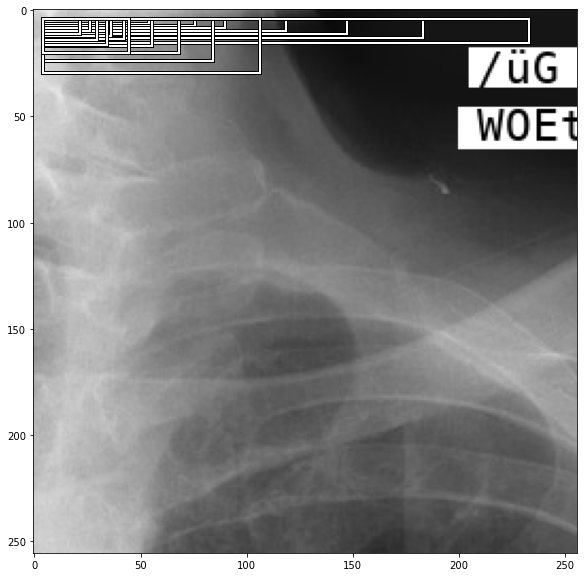

In [96]:
size=256
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[1] + 1) * size / 2 
    y = (bb[0] + 1) * size / 2 
    w = bb[3] * size / 2
    h = bb[2] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [97]:
#all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [98]:
n_classes=data.train_ds.c

crit=RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet50, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=28,sizes=[32,16,8,4], chs=256, final_bias=-4., n_conv=2)

In [99]:
size = 256
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]]) 
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics], metrics=[voc])

In [100]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 6.92E-05


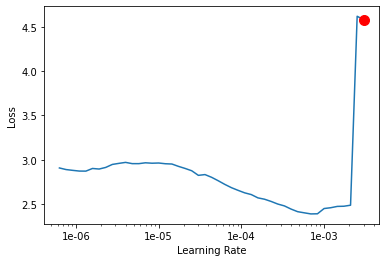

In [38]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

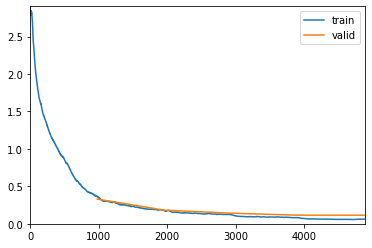

In [39]:
learn.fit_one_cycle(5, 1e-4)

In [40]:
learn.save('stage1-256')

In [41]:
learn.unfreeze()

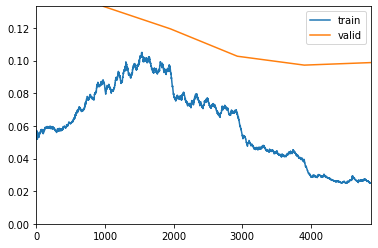

In [42]:
learn.fit_one_cycle(5, (1e-4))#slice(1e-4, 1e-3))

In [43]:
learn.save('stage2-256')

In [101]:
learn.load('stage2-256')

Learner(data=ImageDataBunch;

Train: LabelList (45220 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: /home/jupyter/data/1_class_data/img_dest;

Valid: LabelList (11305 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: /home/jupyter/data/1_class_data/img_dest;

Test: LabelList (16 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /home/jupyter/data/1_class_data/img_dest, model=RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padd

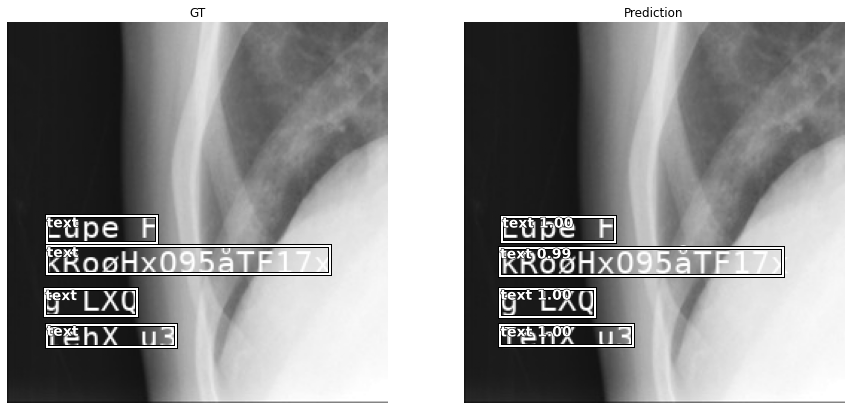

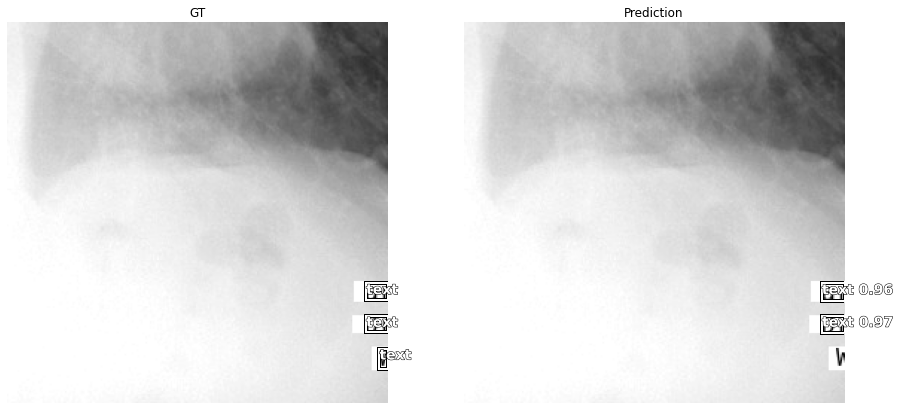

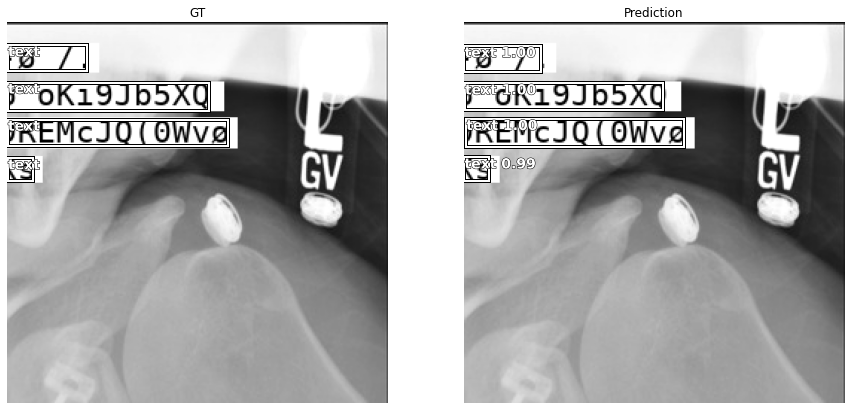

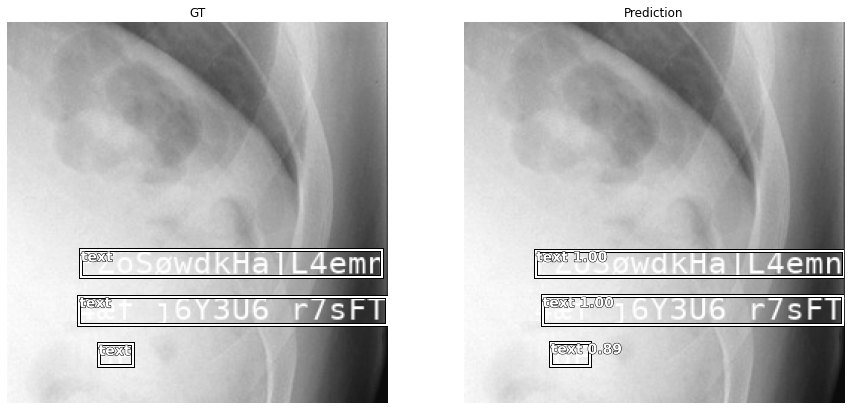

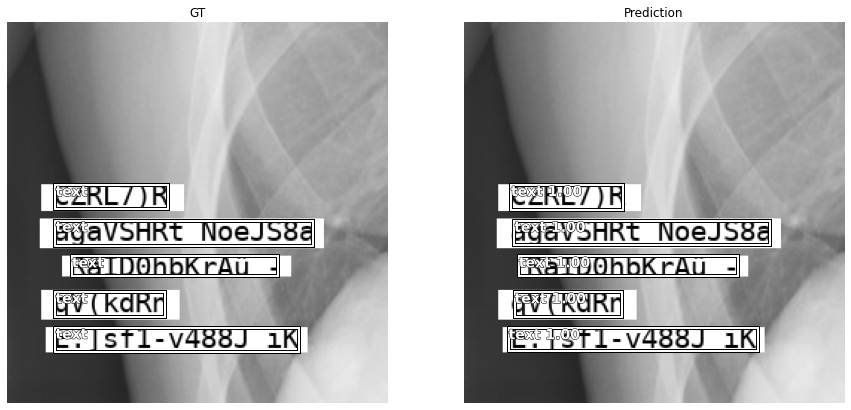

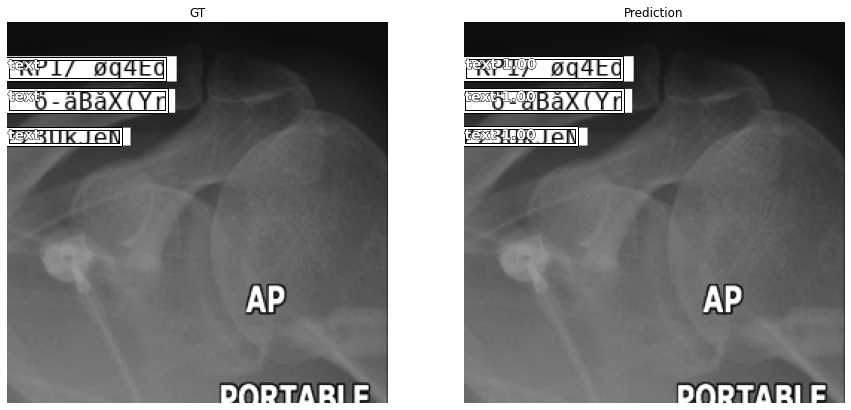

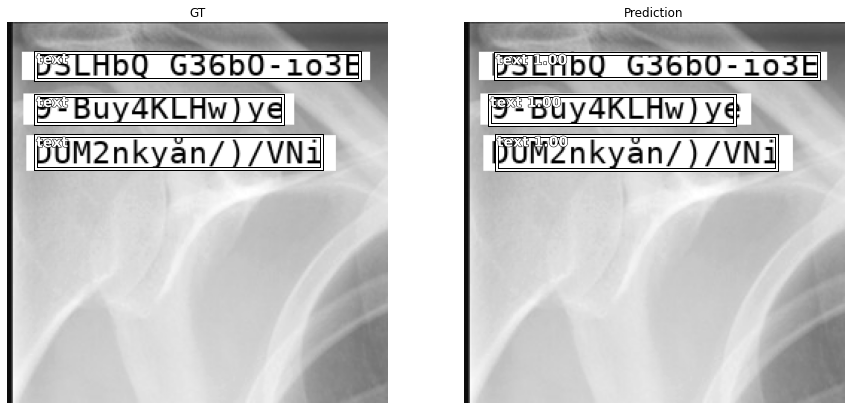

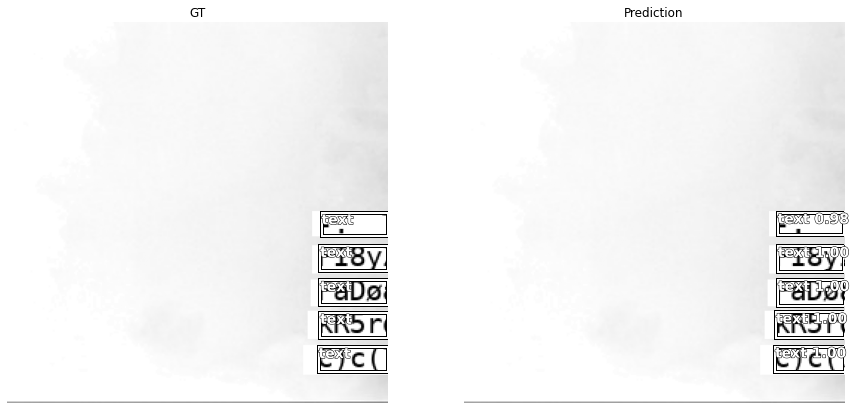

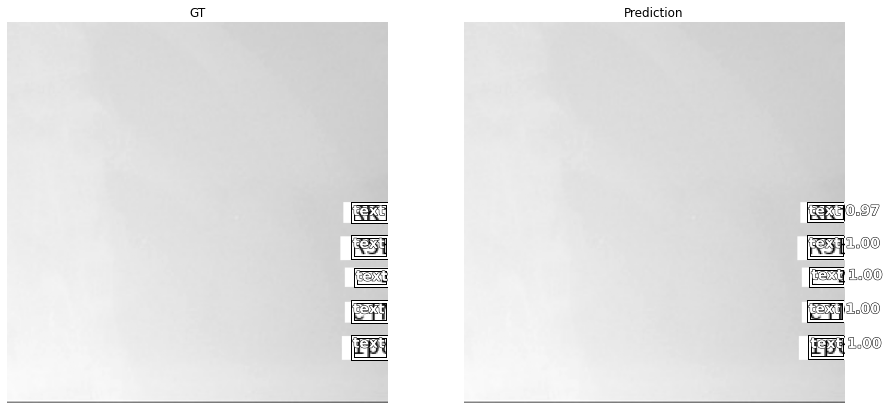

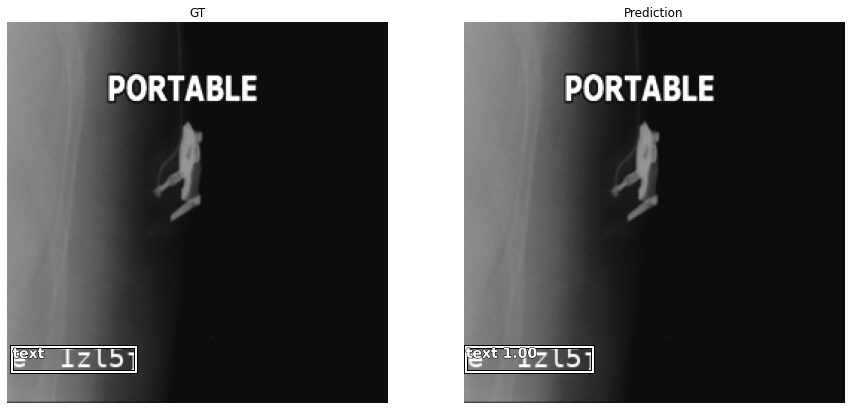

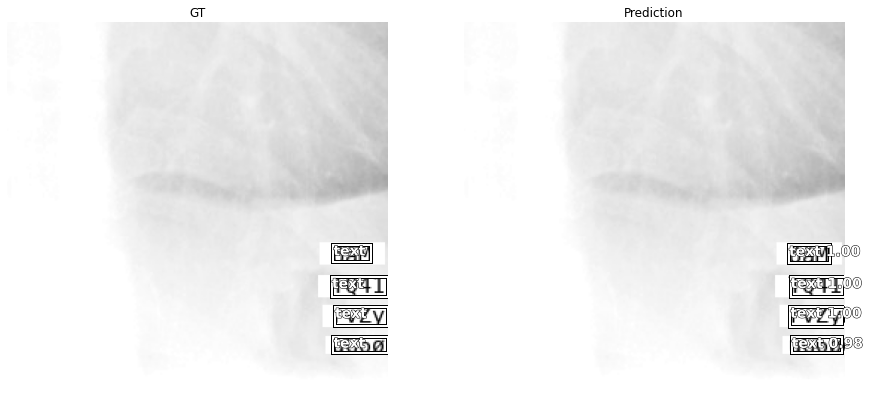

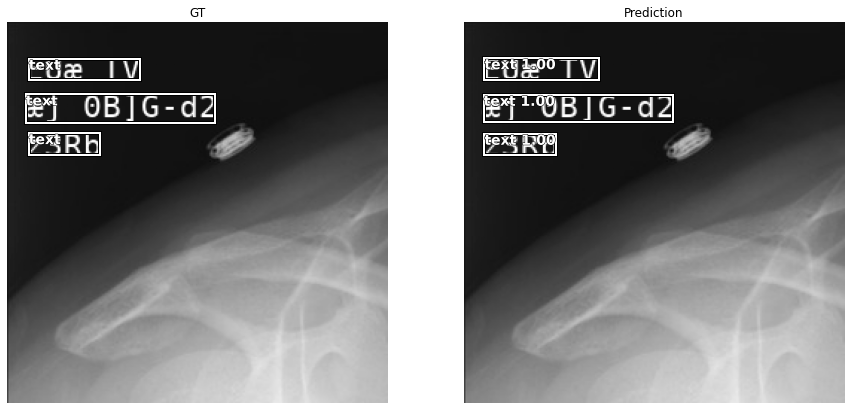

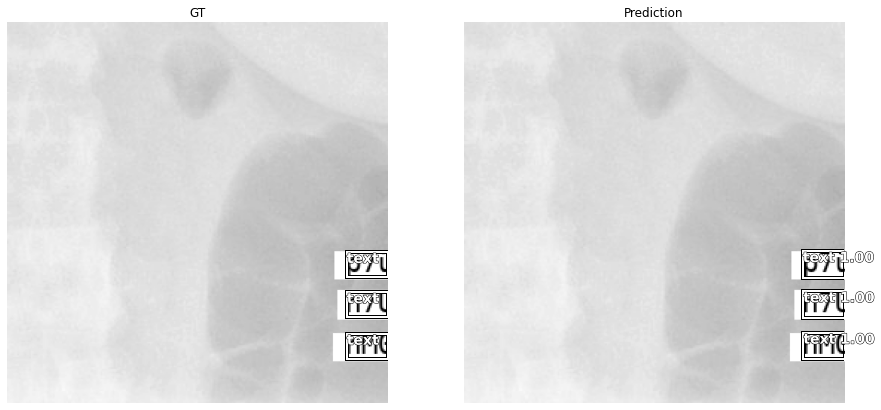

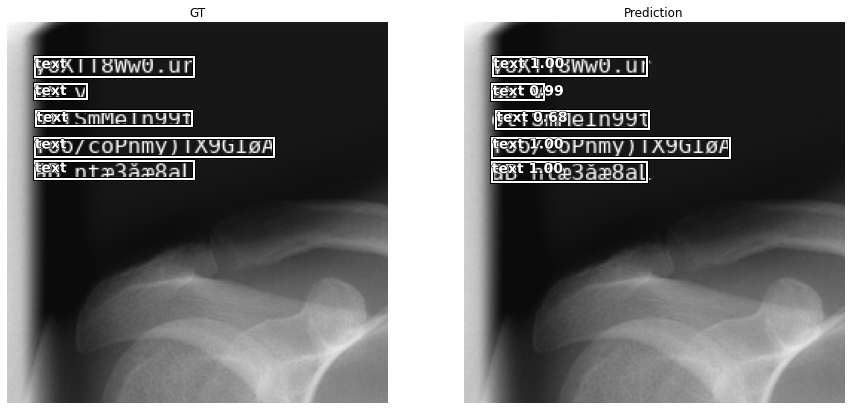

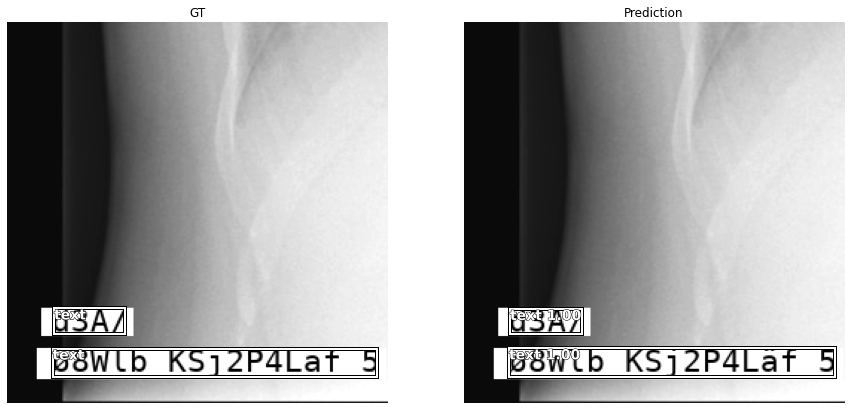

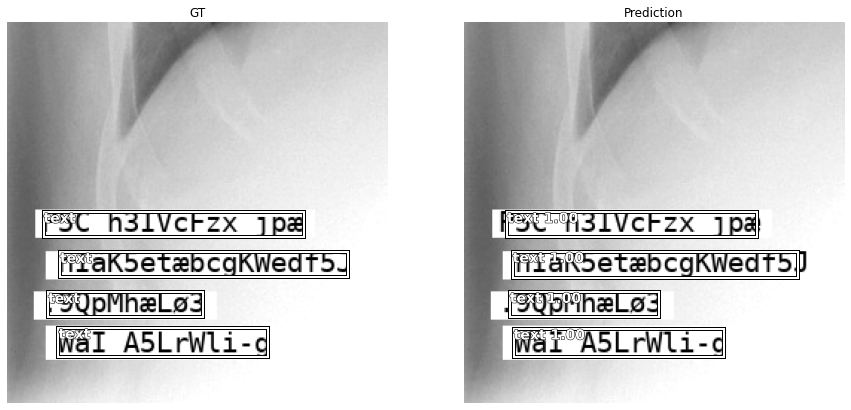

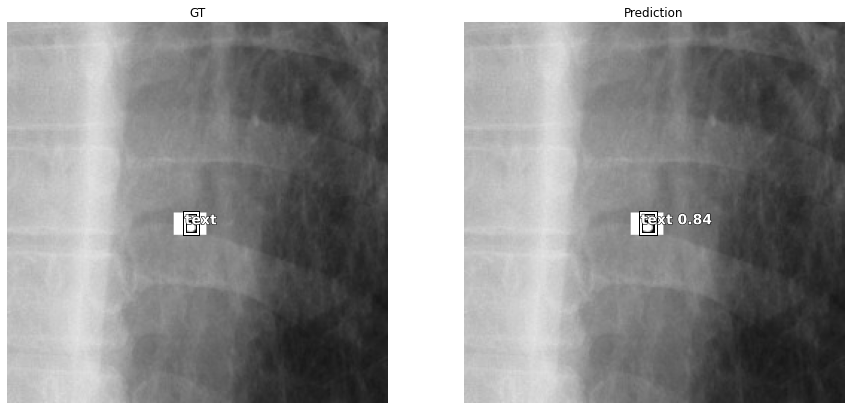

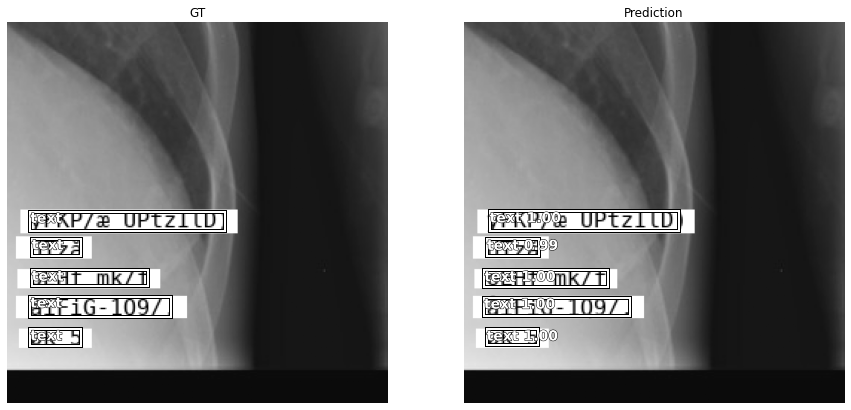

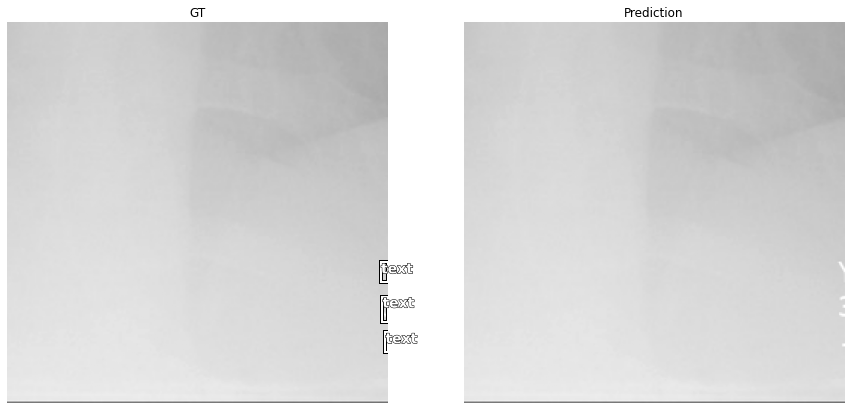

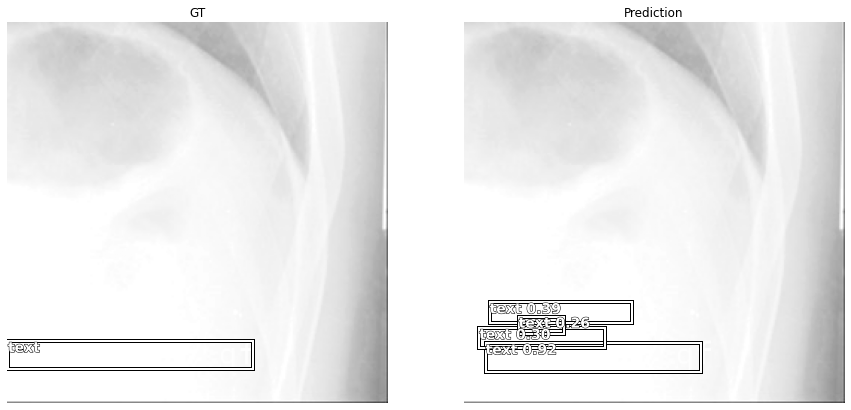

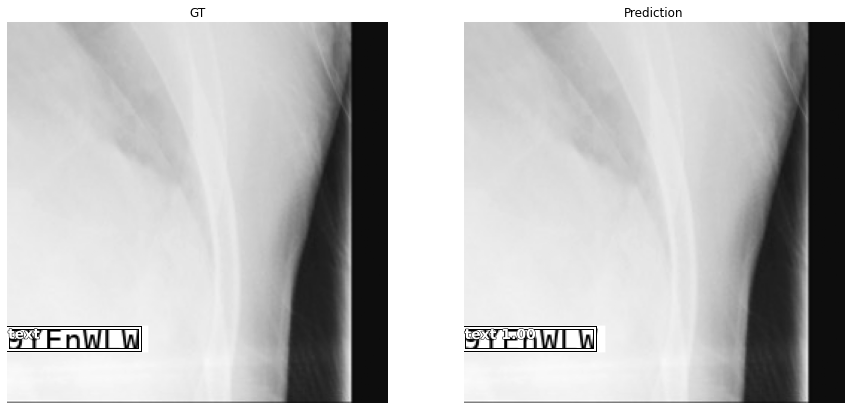

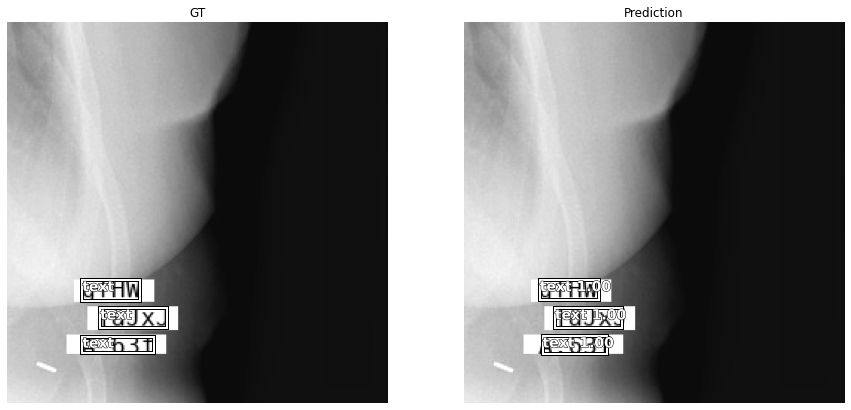

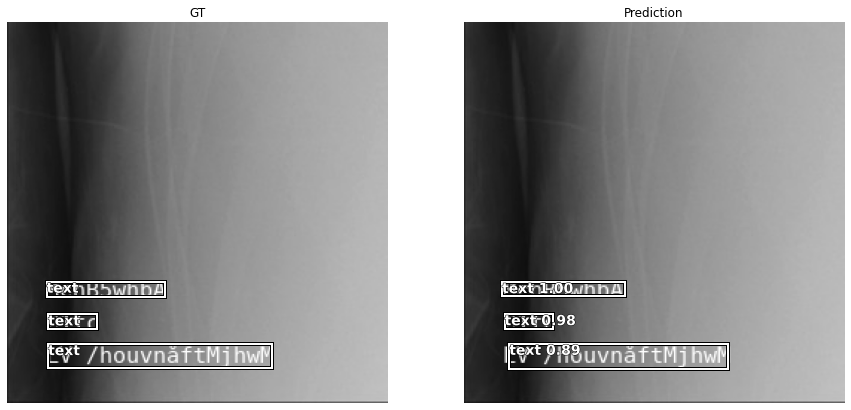

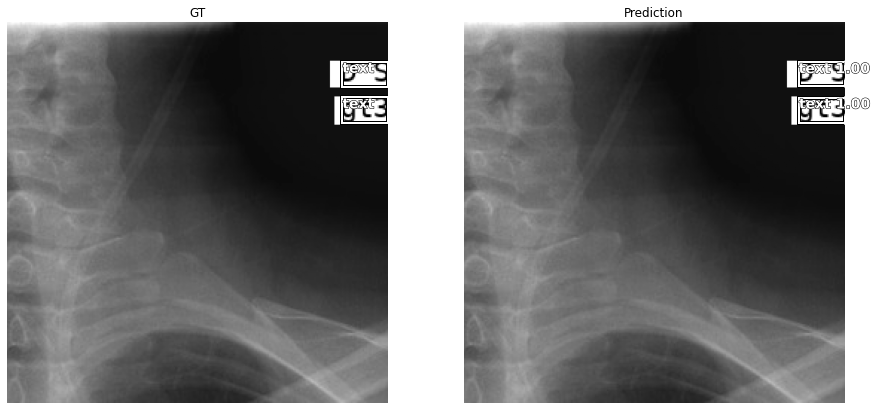

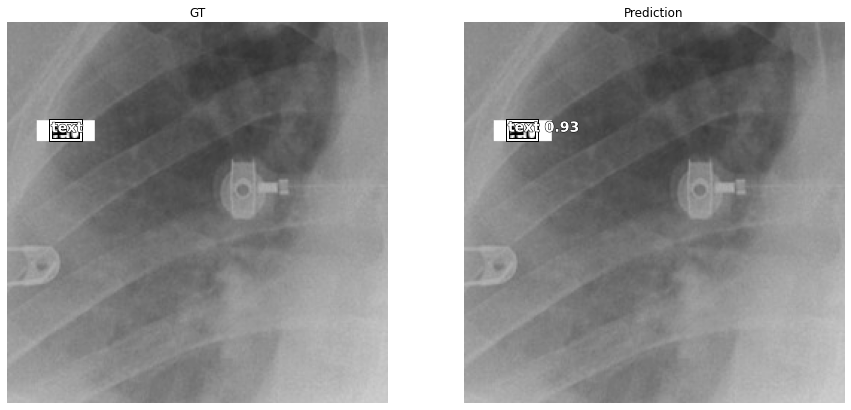

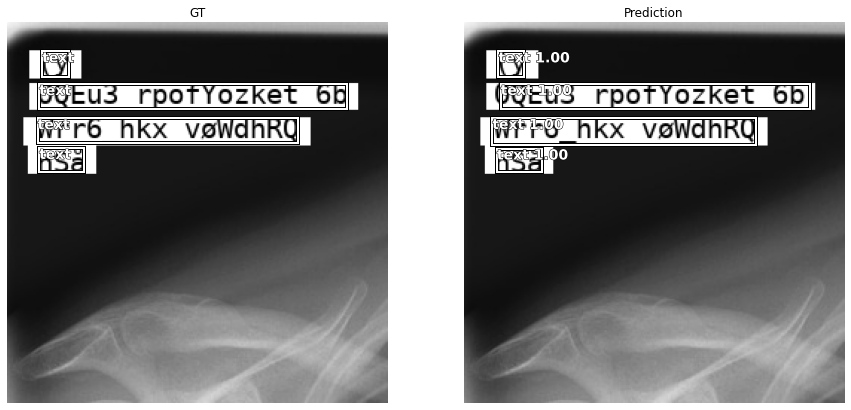

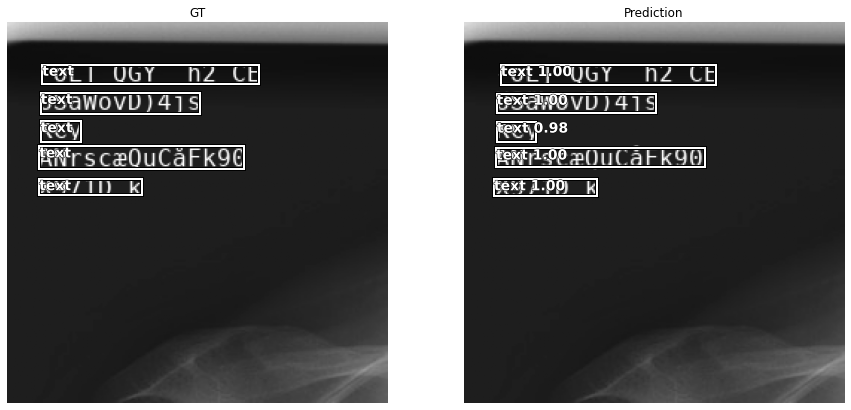

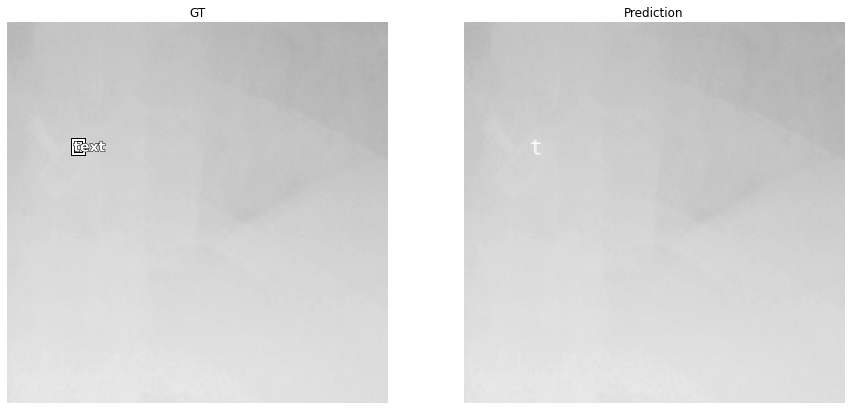

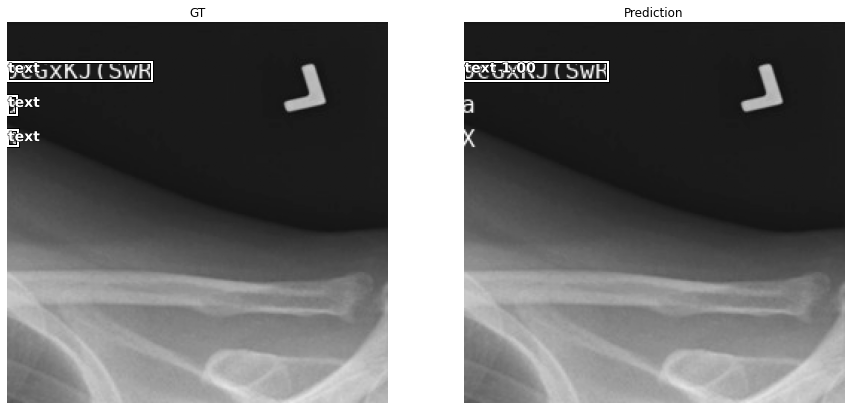

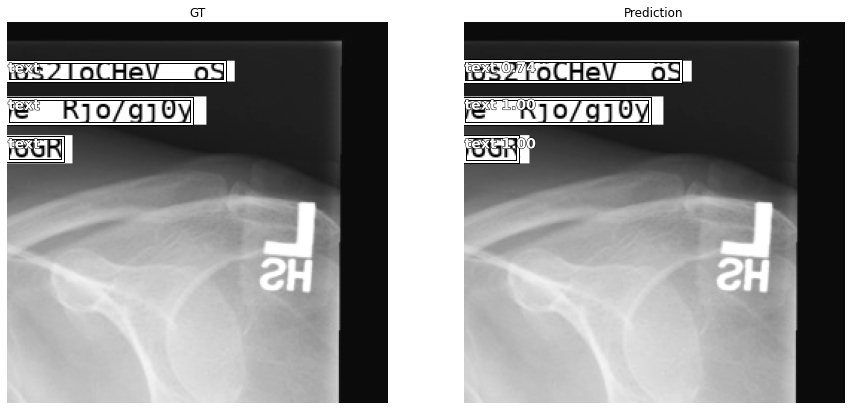

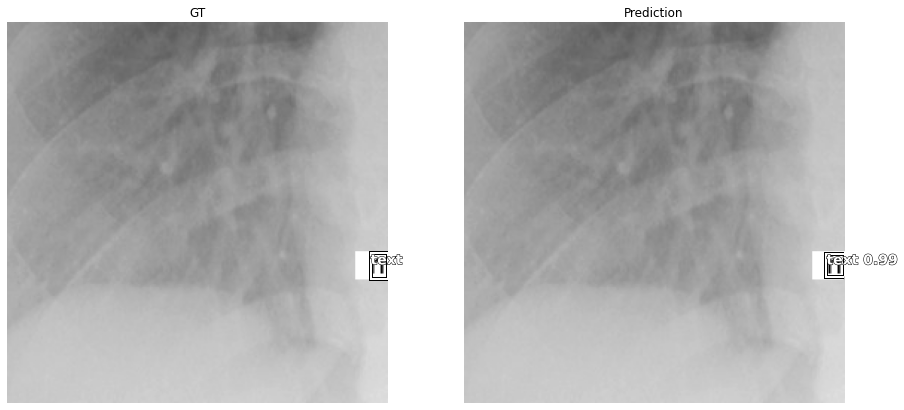

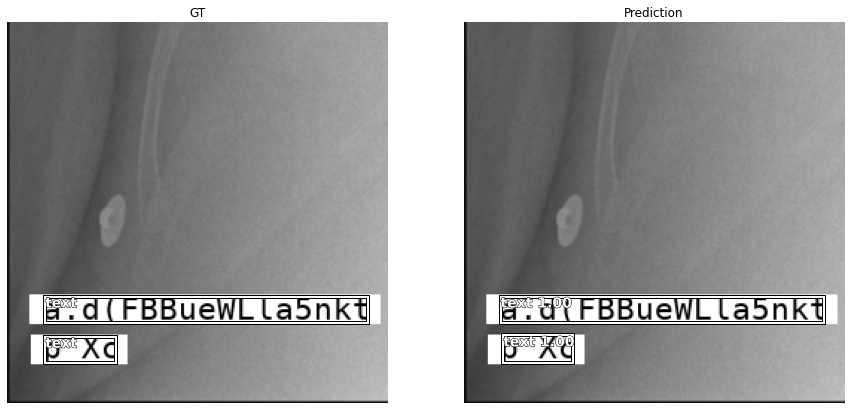

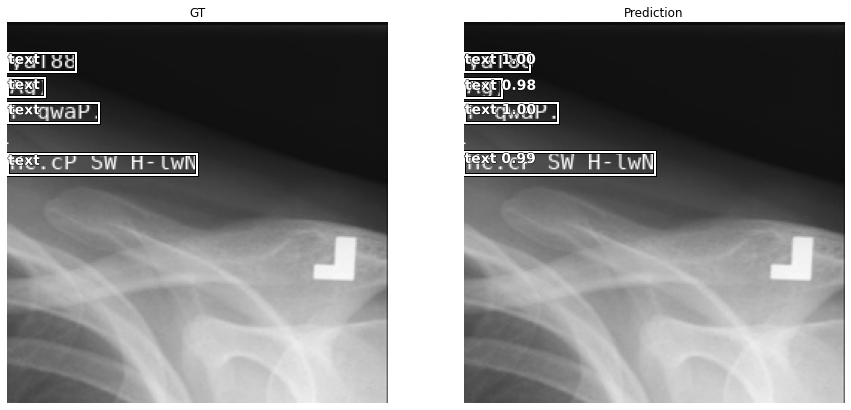

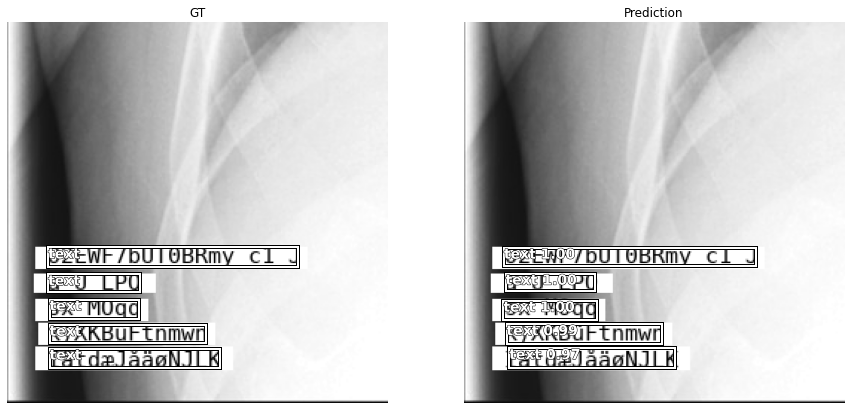

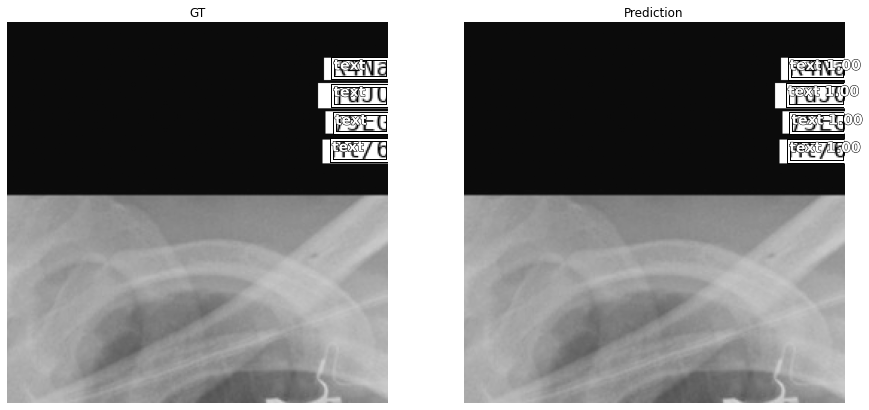

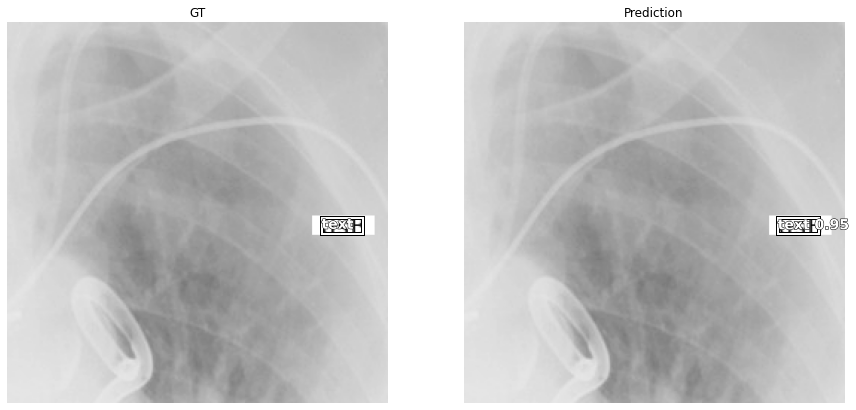

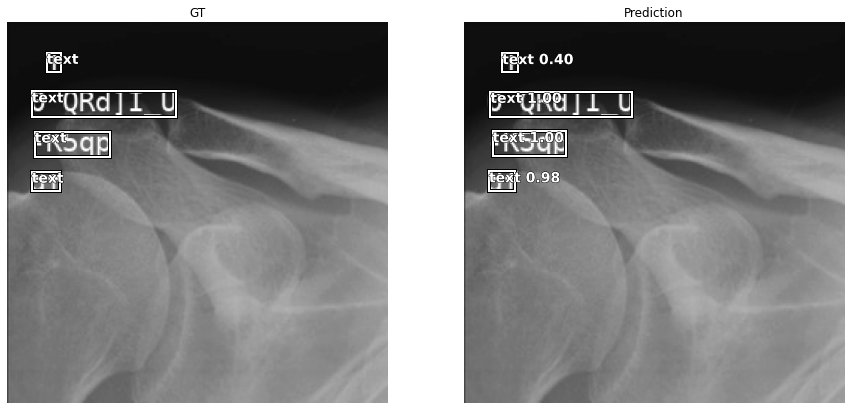

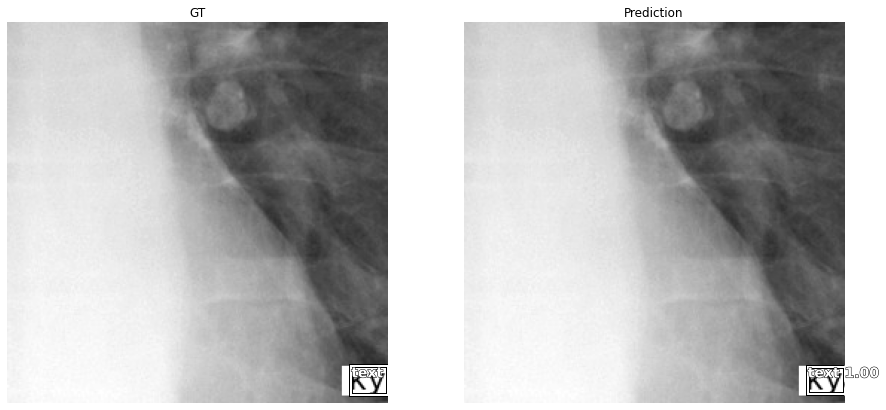

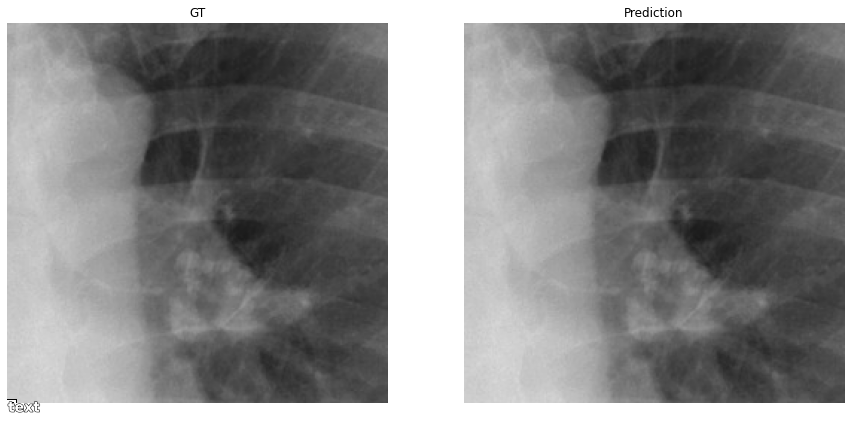

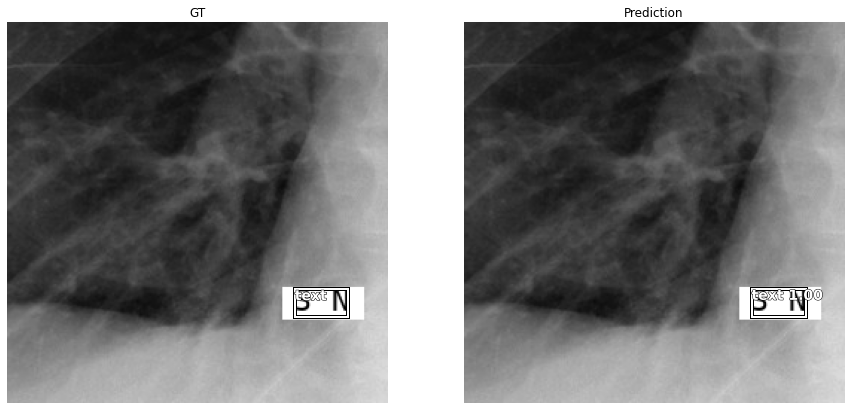

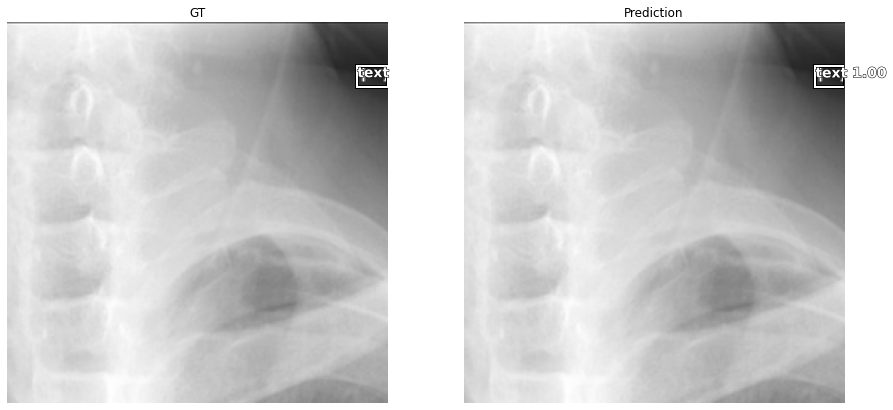

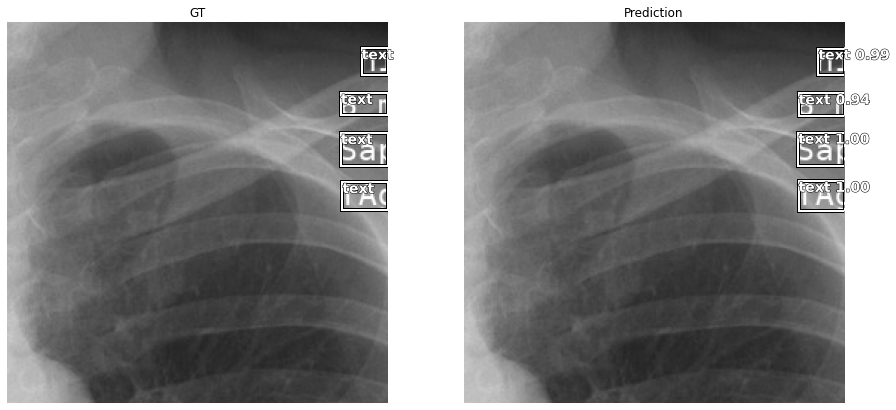

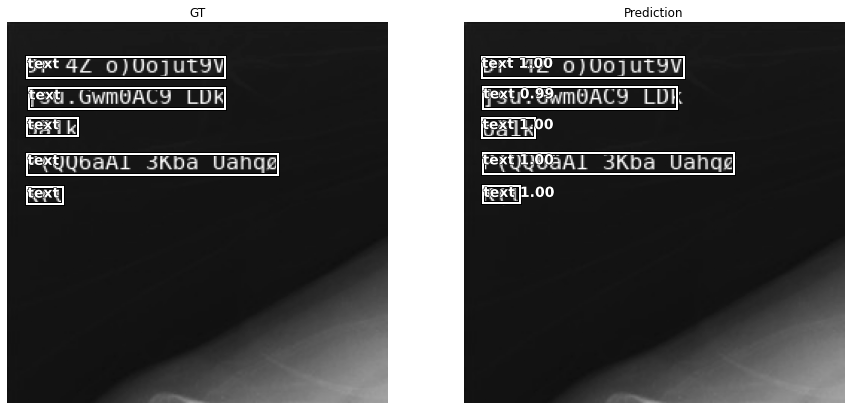

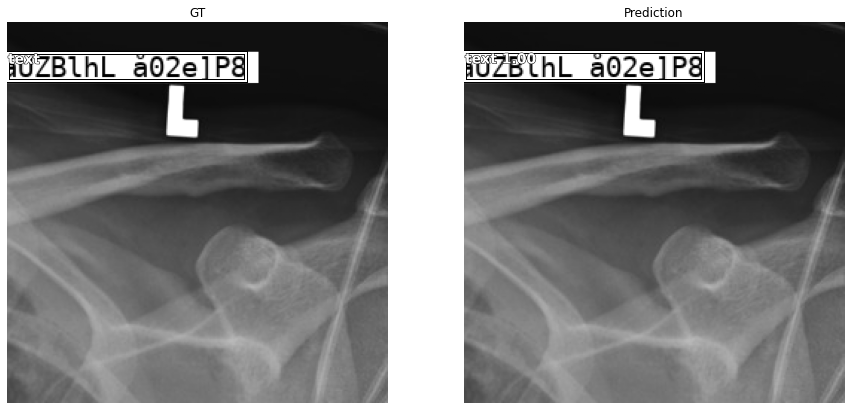

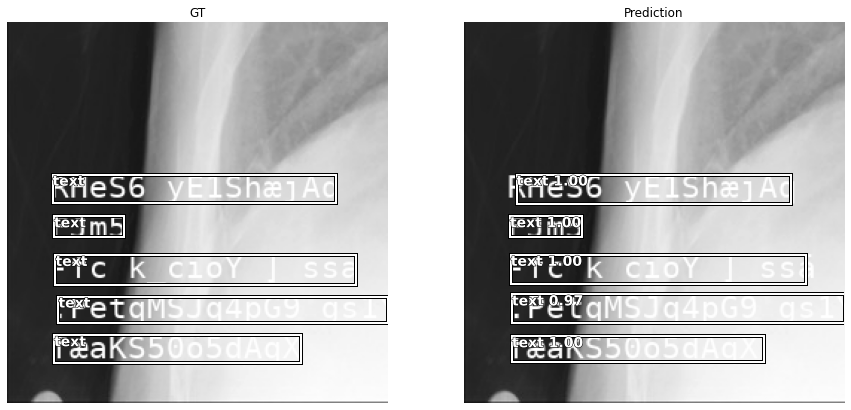

In [49]:
show_results_side_by_side(learn, anchors, detect_thresh=0.25, nms_thresh=0.1, image_count=50)

In [50]:
def show_output(item,bboxs_tot,scores_tot):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(image2np(item.data))
    plt.axis('off')
    area_max = 256**2/5 
    try:
        for bbox, c in zip(bboxs_tot[0], scores_tot[0].numpy()):
            txt = 'text, {0:.4f}'.format(c)
            if bbox[2]*bbox[3] <= area_max:
                draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=txt,text_size=12,color='white')
    except IndexError:
        pass

In [51]:
def process_preds_show(item,clas,bboxs,show_img,cnt,i):
    detect_thresh=0.4   # set your own detection threshold
    nms_thresh=0.1
    pred_string = []
    scores_tot = []
    bboxs_tot = []
    area_max = (256**2)/5
    show_img = True if i<cnt else False
    
    for clas_pred, bbox_pred in list(zip(clas, bboxs)):
        bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_thresh)
        if bbox_pred is not None:
            to_keep = nms(bbox_pred, scores, nms_thresh)
            bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([size])[None].cpu()
        if bbox_pred is not None:
            bbox_pred = to_np(rescale_boxes(bbox_pred, t_sz))
                # change from center to top left
            bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2
            bboxs_tot.append(bbox_pred)
            scores_tot.append(scores)
    if show_img:
        show_output(item,bboxs_tot,scores_tot)   
    try:
        for s,bbx in zip(scores_tot[0].numpy(),bboxs_tot[0]):
            bbx = [int(round(x)) for x in bbx]
            if bbx[2]*bbx[3] <= area_max :
                res = [bbx[1],bbx[0],bbx[3],bbx[2]]
                pred_string.append(res)
        return pred_string
    except IndexError:
        pass


In [52]:
def get_prediction(show_img=True,cnt=20): 
    # Set show img True to see img or else false for bboxs only, cnt for number of images to show
    preds_str = {}
    for i in range(cnt):
        item = learn.data.test_ds[i][0]  #Pick one image
        batch = learn.data.one_item(item)
        clas,bboxs,xtr = learn.pred_batch(batch=batch)
        prd = process_preds_show(item,clas,bboxs,show_img,cnt,i)
        
        
        try:
            preds_str[image_id[i]] = "".join(str(prd))
            print(str(image_id[i]) + " " + preds_str[image_id[i]])
        except TypeError:
            preds_str[image_id[i]] = ""
    return preds_str

00000000_01_01.png [[27, 19, 161, 15], [23, 38, 141, 14], [19, 59, 14, 12]]
00000000_01_02.png None
00000000_01_03.png [[217, 23, 39, 13]]
00000000_01_04.png [[0, 23, 58, 11]]
00000000_02_01.png None
00000000_02_02.png None
00000000_02_03.png None
00000000_02_04.png None
00000000_03_01.png None
00000000_03_02.png None
00000000_03_03.png None
00000000_03_04.png None
00000000_04_01.png [[26, 199, 69, 13], [26, 142, 88, 10], [26, 161, 43, 10], [26, 180, 34, 10], [27, 217, 104, 12]]
00000000_04_02.png None
00000000_04_03.png None
00000000_04_04.png None


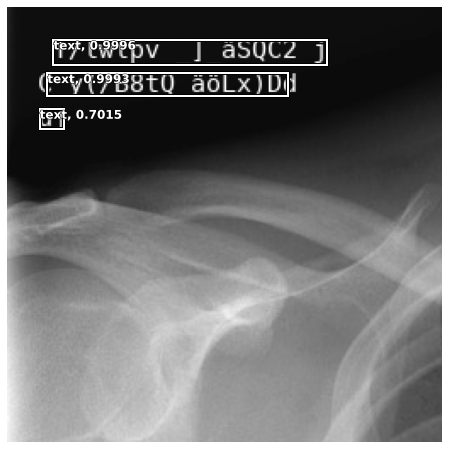

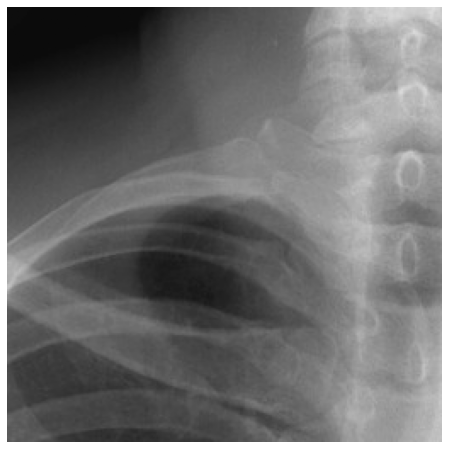

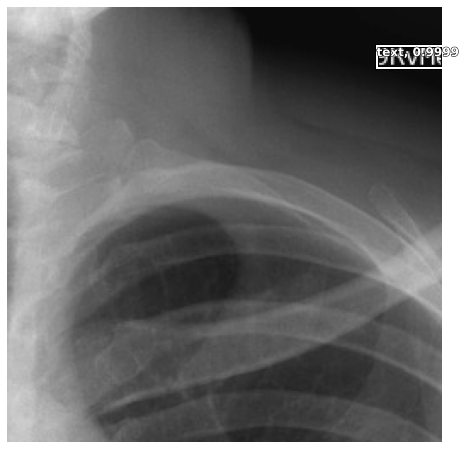

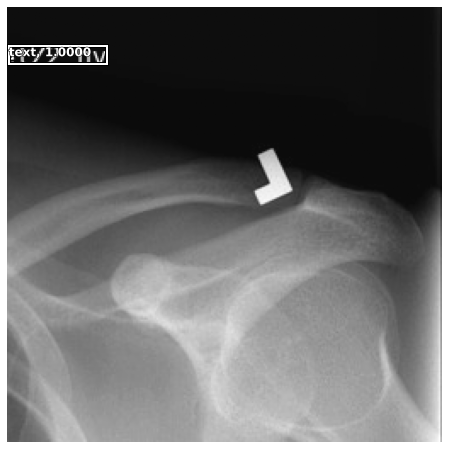

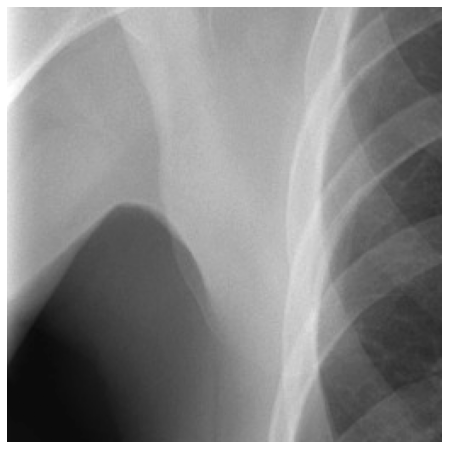

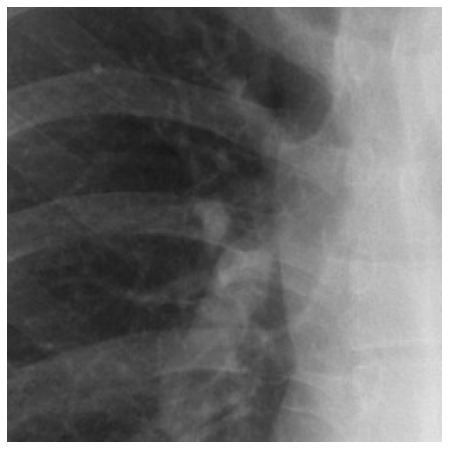

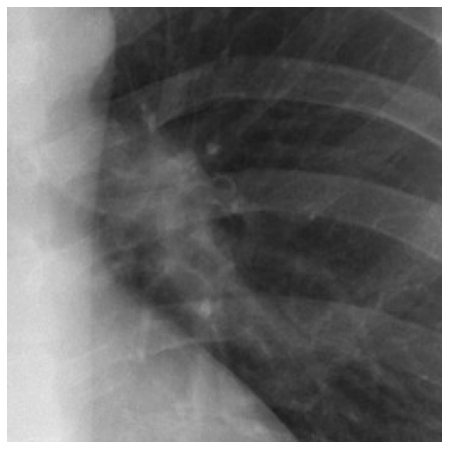

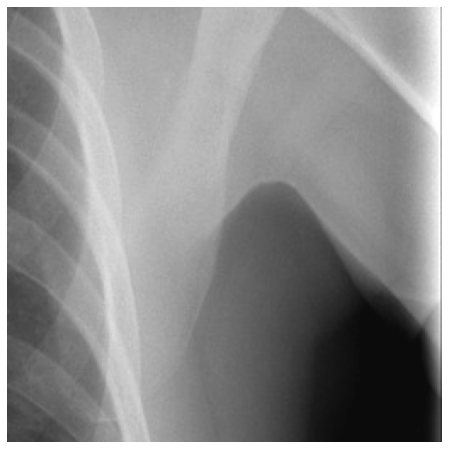

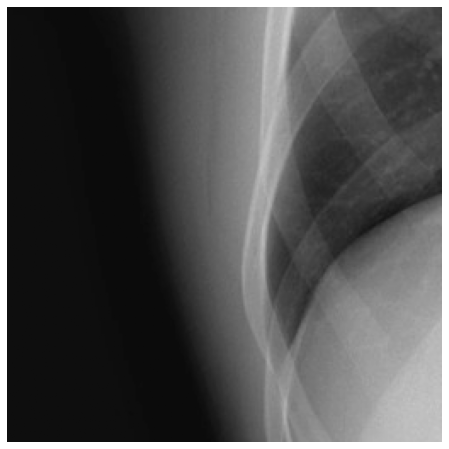

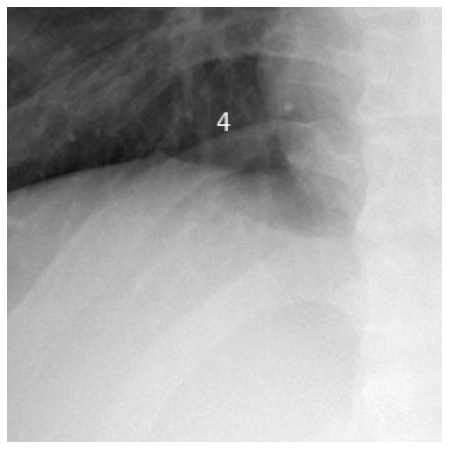

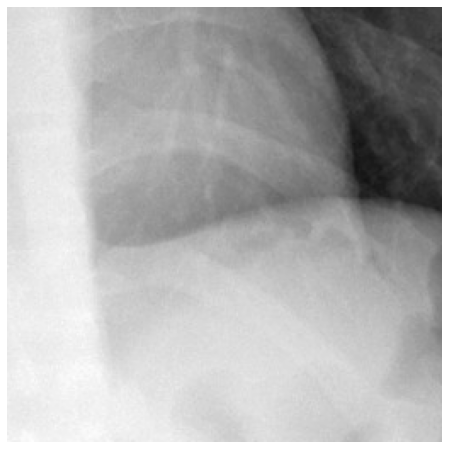

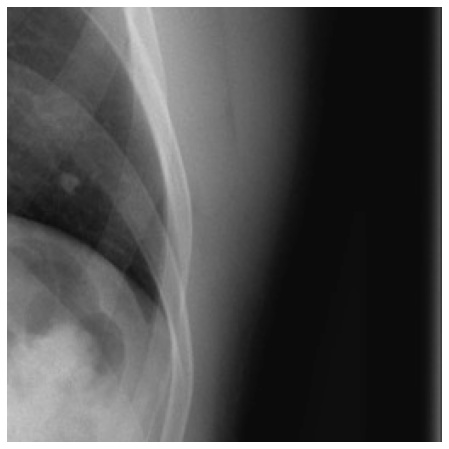

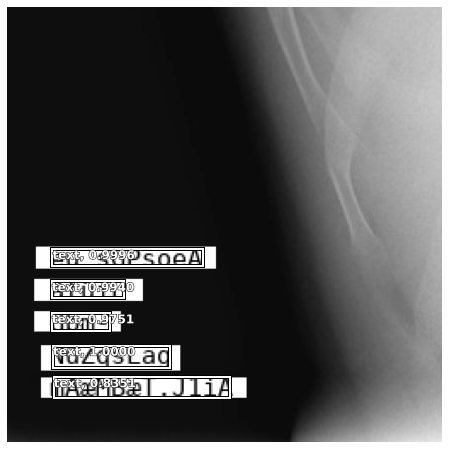

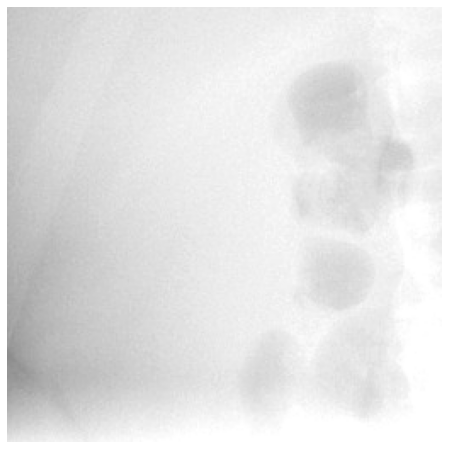

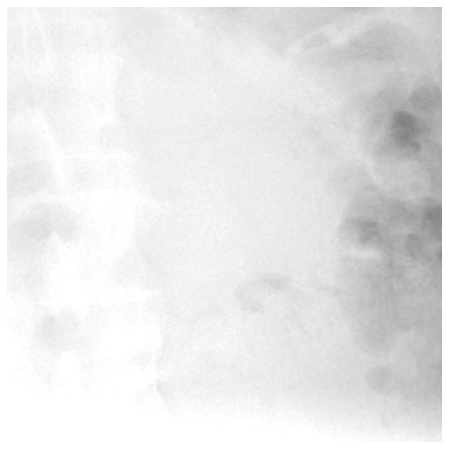

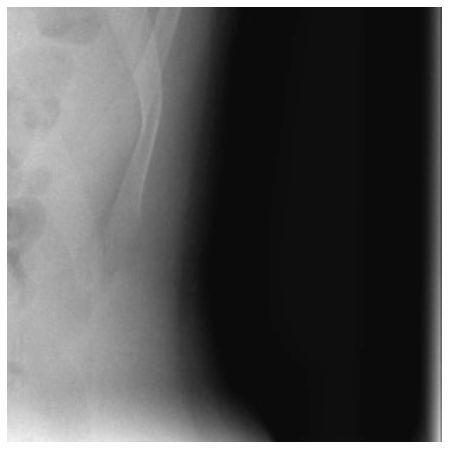

In [61]:
pred = get_prediction(cnt=16)

In [197]:
from PIL import Image
img = Image.open('/home/jupyter/data/1_class_test/img_dest/000001.png')

In [198]:
img.size
[[223, 46, 33, 17]

(256, 256)

In [199]:
img = Image.open('/home/jupyter/data/1_class_test/img_dest/000001.png')
img=img.crop((223,17 ,256,46))
img

In [168]:
fn = pd.Series(pred.keys())

In [169]:
pred.values()

dict_values(['[[27, 19, 161, 15], [23, 38, 141, 14], [19, 59, 14, 12]]', 'None', '[[217, 23, 39, 13]]', '[[0, 23, 58, 11]]', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '[[26, 199, 69, 13], [26, 142, 88, 10], [26, 161, 43, 10], [26, 180, 34, 10], [27, 217, 104, 12]]', 'None', 'None', 'None'])

In [170]:
preds_df = pd.DataFrame()

In [171]:
import ast
preds_df['filename'] = fn
preds_df['bbox'] = pd.Series(pred.values())

In [172]:
preds_df.bbox.values

array(['[[27, 19, 161, 15], [23, 38, 141, 14], [19, 59, 14, 12]]', 'None', '[[217, 23, 39, 13]]', '[[0, 23, 58, 11]]',
       'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       '[[26, 199, 69, 13], [26, 142, 88, 10], [26, 161, 43, 10], [26, 180, 34, 10], [27, 217, 104, 12]]', 'None',
       'None', 'None'], dtype=object)

In [173]:
preds_df = preds_df.replace(to_replace='None', value=np.nan).dropna()

In [234]:
preds_df.bbox.values

array(['[[27, 19, 161, 15], [23, 38, 141, 14], [19, 59, 14, 12]]', '[[217, 23, 39, 13]]', '[[0, 23, 58, 11]]',
       '[[26, 199, 69, 13], [26, 142, 88, 10], [26, 161, 43, 10], [26, 180, 34, 10], [27, 217, 104, 12]]'],
      dtype=object)

In [103]:
learn.export()

In [110]:
learn =load_learner(img_path)

In [219]:
def new_coords(nameX, nameY, bounding_box):
    X=0
    Y=0
    xmax=0
    ymax=0
    if nameX == '01':
        X=bounding_box[0]
        xmax=bounding_box[2]+X
    elif nameX == '02':
        X=bounding_box[0] + 256
        xmax=bounding_box[2] + X 
    elif nameX == '03':
        X=bounding_box[0] + 512
        xmax=bounding_box[2] +X 
    elif nameX == '04':
        X=bounding_box[0] + 768
        xmax=bounding_box[2] + X
    
    if nameY == '01':
        Y=bounding_box[1]
        ymax = Y + bounding_box[3]
    elif nameY == '02':
        Y=bounding_box[1] + 256
        ymax = Y + bounding_box[3]
    elif nameY == '03':
        Y=bounding_box[1] + 512
        ymax = Y + bounding_box[3]
    elif nameY == '04':
        Y=bounding_box[1] + 768
        ymax = Y+bounding_box[3]

    newX = X
    newY = Y
    newXmax = xmax
    newYmax = ymax
    new_bbox = [newX, newY, newXmax, newYmax]
    return new_bbox

In [276]:
def newDF(names, bboxes):
    final_DF = pd.DataFrame(columns=['filename','xmin', 'ymin','xmax','ymax'])
    for name,bbox in zip(names,range(len(bboxes))):
        
        navn = name[9:]
        filename=name[:8] + '.png'
        navn = navn.replace('.png', '')
        nameX = navn[3:]
        nameY = navn[:2]
        literal_boxes = ast.literal_eval(bboxes[bbox])
        for i in range(len(literal_boxes)):
            try:
                if len(literal_boxes[i]) >= 0:
                    lit_box = ast.literal_eval(bboxes[bbox])
                    bounding_box = lit_box[i]
                    new_bbox = new_coords(nameX, nameY, bounding_box)
                    final_DF = final_DF.append({'filename':filename,'xmin': new_bbox[0],'ymin': new_bbox[1],
                                            'xmax': new_bbox[2],'ymax': new_bbox[3]}, ignore_index=True)
            except IndexError:
                pass          
    return final_DF

In [277]:
final_df = newDF(preds_df.filename, preds_df.bbox.values)

3
1
1
5


In [278]:
len(preds_df.bbox)

4

In [279]:
preds_df.bbox.values.shape

(4,)

In [280]:
final_df

filename xmin ymin xmax ymax
0  00000000.png   27   19  188   34
1  00000000.png   23   38  164   52
2  00000000.png   19   59   33   71
3  00000000.png  729   23  768   36
4  00000000.png  768   23  826   34
5  00000000.png   26  967   95  980
6  00000000.png   26  910  114  920
7  00000000.png   26  929   69  939
8  00000000.png   26  948   60  958
9  00000000.png   27  985  131  997

Alt under her er bare litt testing fra min side

In [54]:
boxes

array(['[[27, 19, 161, 15], [23, 38, 141, 14], [19, 59, 14, 12]]', '[[217, 23, 39, 13]]', '[[0, 23, 58, 11]]',
       '[[26, 199, 69, 13], [26, 142, 88, 10], [26, 161, 43, 10], [26, 180, 34, 10], [27, 217, 104, 12]]'],
      dtype=object)

In [58]:
ast.literal_eval(boxes[3])

[[26, 199, 69, 13],
 [26, 142, 88, 10],
 [26, 161, 43, 10],
 [26, 180, 34, 10],
 [27, 217, 104, 12]]

In [55]:
import image_slicer
test_images = image_slicer.open_images_in((str(test_img_path) + '/with_text/'))

In [56]:
from PIL import Image

In [57]:
joines_img = image_slicer.join(test_images)
joined_image=open_image(str(test_img_path) + '/with_text/00000000.png')

In [281]:
test_box = ImageBBox.create(*joines_img.size, [[948,26,958,60],[19,27,34,188],[38,23,52,164],[59,19,71,33],[23,729,36,768],[23,768,34,826],[967,26,980,95],
                                              [910,26,920,114],[929,26,939,69],[985, 27, 997,131]])

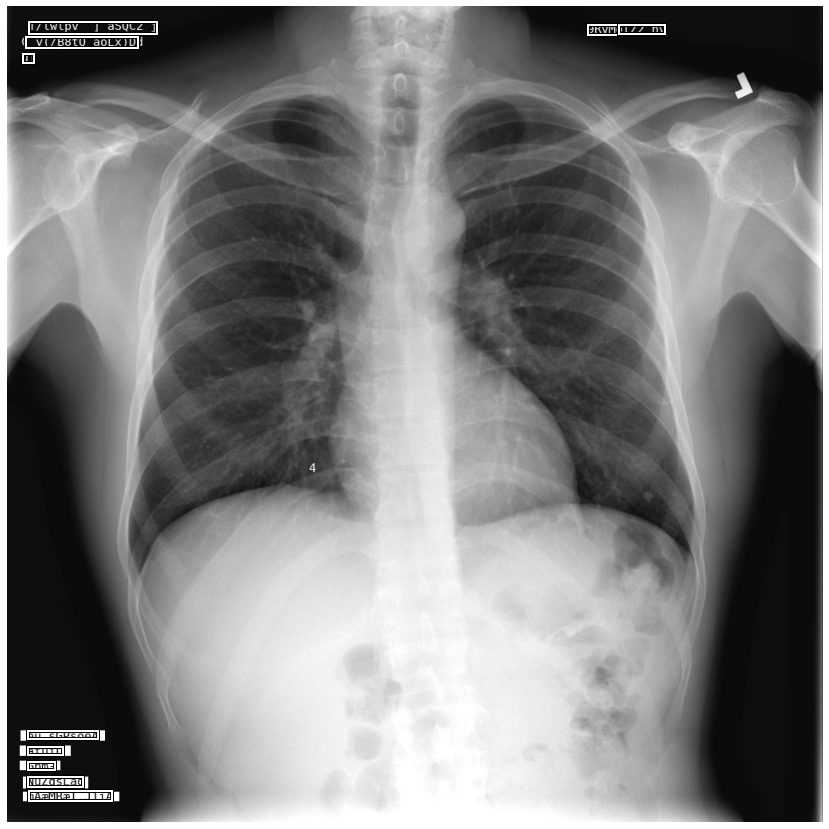

In [282]:
joined_image.show(figsize=(15,15),y=test_box)